In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hem-3-folder/dataset/validation/no/aug_82_4270.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_46_3843.png
/kaggle/input/hem-3-folder/dataset/validation/no/173.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_0_6383.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_46_4961.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_61_630.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_40_2606.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_96_2781.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_29_4856.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_41_4007.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_27_152.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_98_2145.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_1_5807.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_13_4833.png
/kaggle/input/hem-3-folder/dataset/validation/no/162.png
/kaggle/input/hem-3-folder/dataset/validation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import cv2
import shutil
import itertools

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras.models import Model, Sequential
from keras.layers import TimeDistributed, Dense, Flatten, Dropout, Bidirectional, LSTM, GRU
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

RANDOM_SEED = 42

In [3]:
train_dir = "../input/hem-3-folder/dataset/train/"
validation_dir = "../input/hem-3-folder/dataset/validation/"
test_dir = "../input/hem-3-folder/dataset/test/"

In [4]:
def load_data(dir_path):
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [5]:
X_train, y_train, labels = load_data(train_dir)
X_test, y_test, _ = load_data(test_dir)
X_val, y_val, _ = load_data(validation_dir)

100%|██████████| 2/2 [00:15<00:00,  7.56s/it]


1536 images loaded from ../input/hem-3-folder/dataset/train/ directory.


100%|██████████| 2/2 [00:04<00:00,  2.43s/it]


480 images loaded from ../input/hem-3-folder/dataset/test/ directory.


100%|██████████| 2/2 [00:03<00:00,  1.92s/it]

384 images loaded from ../input/hem-3-folder/dataset/validation/ directory.


In [6]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1536, 227, 227, 3)
(480, 227, 227, 3)
(384, 227, 227, 3)


In [7]:
X_train = np.array([cv2.resize(image, (224, 224)) for image in X_train])
X_test = np.array([cv2.resize(image, (224, 224)) for image in X_test])
X_val = np.array([cv2.resize(image, (224, 224)) for image in X_val])

In [8]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1536, 224, 224, 3)
(480, 224, 224, 3)
(384, 224, 224, 3)


In [9]:
input_shape = (224,224, 3)
batch_size = 32

In [10]:
training_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
train_generator = training_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

val_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1536 images belonging to 2 classes.
Found 384 images belonging to 2 classes.


In [12]:
pretrained_vgg19_model = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False ,input_shape=[224, 224, 3])
pretrained_vgg19_model.trainable = False

2022-03-17 22:10:11.897428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-17 22:10:12.073152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-17 22:10:12.073883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-17 22:10:12.075001: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 1s 0us/step


In [13]:
def print_layer_trainable():
    for layer in pretrained_vgg19_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_conv4
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_conv4
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_conv4
False:	block5_pool


In [14]:
from keras.layers import TimeDistributed, Dense, Flatten, Dropout, Bidirectional, LSTM, GRU

model_vgg19 = tf.keras.Sequential([
                             pretrained_vgg19_model,
#                              tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(128, activation='relu'), #1000
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1, activation='sigmoid')
                             ])

model_vgg19.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

model_vgg19.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 23,235,905
Trainable params: 3,211,521
Non-trainable params: 20,024,384
_________________________________________________________________


In [15]:
EPOCHS = 50
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
#     monitor='val_loss',
    factor=0.6,
    patience=3,
    min_lr=1e-6,
#     min_delta=0.000001,
    verbose=1)

# es = EarlyStopping(
#     monitor='val_accuracy', 
#     mode='max',
#     patience=6
# )
filename = 'vgg19.h5'
check_pt = ModelCheckpoint(
    filename,
    monitor="val_accuracy",
#     monitor='val_loss',
    verbose=1,
    save_best_only=True
)

# history = model.fit(train_generator, epochs=EPOCHS, batch_size=16, validation_data=val_generator, callbacks=[reduce_lr, es, check_pt])
history = model_vgg19.fit(train_generator, epochs=EPOCHS, batch_size=16, validation_data=val_generator, callbacks=[reduce_lr, check_pt])


2022-03-17 22:10:16.404460: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-03-17 22:10:17.955583: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


48/48 [==============================] - 17s 161ms/step - loss: 0.6661 - accuracy: 0.6270 - val_loss: 0.5064 - val_accuracy: 0.8151

Epoch 00001: val_accuracy improved from -inf to 0.81510, saving model to vgg19.h5
Epoch 2/50
48/48 [==============================] - 7s 155ms/step - loss: 0.4646 - accuracy: 0.7969 - val_loss: 0.5017 - val_accuracy: 0.7370

Epoch 00002: val_accuracy did not improve from 0.81510
Epoch 3/50
48/48 [==============================] - 8s 162ms/step - loss: 0.3904 - accuracy: 0.8405 - val_loss: 0.3531 - val_accuracy: 0.8750

Epoch 00003: val_accuracy improved from 0.81510 to 0.87500, saving model to vgg19.h5
Epoch 4/50
48/48 [==============================] - 7s 143ms/step - loss: 0.3285 - accuracy: 0.8809 - val_loss: 0.3209 - val_accuracy: 0.8776

Epoch 00004: val_accuracy improved from 0.87500 to 0.87760, saving model to vgg19.h5
Epoch 5/50
48/48 [==============================] - 7s 143ms/step - loss: 0.2799 - accuracy: 0.9115 - val_loss: 0.2790 - val_accura

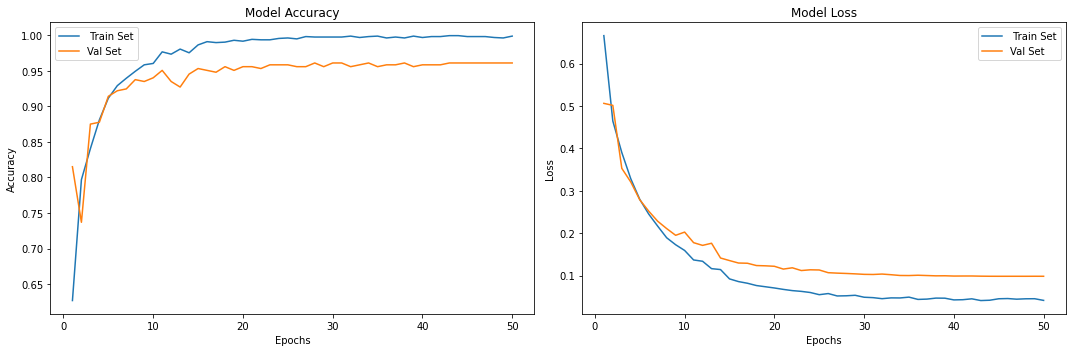

In [16]:
epochs_range = range(1, len(history.epoch) + 1)
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history["accuracy"], label=' Train Set')
plt.plot(epochs_range, history.history["val_accuracy"], label='Val Set')
# plt.plot(28, 0.9766, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="red")
# plt.axvline(x=28, color="black")
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history["loss"], label=' Train Set')
plt.plot(epochs_range, history.history["val_loss"], label='Val Set')
# plt.plot(28, 0.0750, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="red")
# plt.axvline(x=28, color="black")
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend(loc="best")
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [17]:
from tensorflow.keras.models import load_model
saved_model = load_model('./vgg19.h5')

In [18]:
# validation
predictions = saved_model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, val_acc = saved_model.evaluate(X_val, y_val, verbose=0)

print('Train: %.4f, Val: %.4f' % (train_acc, val_acc))

accuracy = accuracy_score(y_val, predictions)
print('Validation Accuracy = %.4f' % accuracy)

# precision: tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

#KAPPA SCORE
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)

  # ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)
 
# confusion matrix
matrix = confusion_matrix(y_val, predictions)
print(matrix)

tn, fp, fn, tp = matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
            ", False positive:", fp, ", False negative:", fn)

Train: 0.8971, Val: 0.8750
Validation Accuracy = 0.8750
Precision: 0.950000
Recall: 0.791667
F1 score: 0.863636
Cohens kappa: 0.750000
ROC AUC: 0.875000
[[184   8]
 [ 40 152]]
True positive: 152 , True negative: 184 , False positive: 8 , False negative: 40


Train: 0.8971, Test: 0.8667
Test Accuracy = 0.8667
Precision: 0.940000
Recall: 0.783333
F1 score: 0.854545
Cohens kappa: 0.733333
ROC AUC: 0.866667
[[228  12]
 [ 52 188]]
True positive: 188 , True negative: 228 , False positive: 12 , False negative: 52
Sensitivity: 0.7833
Specificity: 0.9500


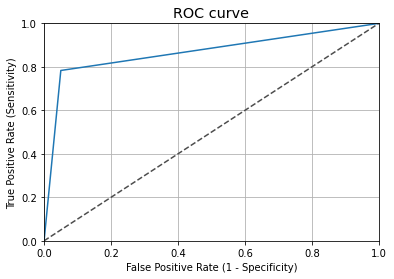

In [19]:
# test
predictions = saved_model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)

print('Train: %.4f, Test: %.4f' % (train_acc, test_acc))

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.4f' % accuracy)

# precision: tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)

#KAPPA SCORE
kappa = cohen_kappa_score(y_test, predictions)
print('Cohens kappa: %f' % kappa)

  # ROC AUC
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)
 
# confusion matrix
matrix = confusion_matrix(y_test, predictions)
print(matrix)

tn, fp, fn, tp = matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
            ", False positive:", fp, ", False negative:", fn)

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

fpr, tpr, thresholds = roc_curve(y_test, predictions)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)